# Input data

In [1]:
import scipy.io as spio
import numpy as np

In [2]:
BahramFace = spio.loadmat(file_name='../data/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='../data/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='../data/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='../data/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='../data/bci-project-data-RAW/SarahFace.mat')

In [3]:
# Deviding the input data into train and validation
length = int(BahramFace['Intensification_Data'].shape[0] * 0.30)
length

1080

In [4]:
FacesDataAll = np.vstack(tup=(BahramFace['Intensification_Data'][:], 
                       DJFace['Intensification_Data'][:], 
                       NickFace['Intensification_Data'][:],
                      RoohiFace['Intensification_Data'][:],
                      SarahFace['Intensification_Data'][:]))

FacesDataTrain = np.vstack(tup=(BahramFace['Intensification_Data'][:-length], 
                       DJFace['Intensification_Data'][:-length], 
                       NickFace['Intensification_Data'][:-length],
                      RoohiFace['Intensification_Data'][:-length],
                      SarahFace['Intensification_Data'][:-length]))

FacesDataTest = np.vstack(tup=(BahramFace['Intensification_Data'][-length:], 
                       DJFace['Intensification_Data'][-length:], 
                       NickFace['Intensification_Data'][-length:],
                      RoohiFace['Intensification_Data'][-length:],
                      SarahFace['Intensification_Data'][-length:]))

In [5]:
(FacesDataAll.shape, FacesDataAll.dtype, 
 FacesDataTest.shape, FacesDataTest.dtype, 
 FacesDataTrain.shape, FacesDataTrain.dtype)

((18720, 205, 16),
 dtype('<f8'),
 (5400, 205, 16),
 dtype('<f8'),
 (13320, 205, 16),
 dtype('<f8'))

In [6]:
FacesLabelAll = np.vstack(tup=(BahramFace['Intensification_Label'][:], 
                       DJFace['Intensification_Label'][:], 
                       NickFace['Intensification_Label'][:],
                      RoohiFace['Intensification_Label'][:],
                      SarahFace['Intensification_Label'][:]))

FacesLabelTrain = np.vstack(tup=(BahramFace['Intensification_Label'][:-length], 
                       DJFace['Intensification_Label'][:-length], 
                       NickFace['Intensification_Label'][:-length],
                      RoohiFace['Intensification_Label'][:-length],
                      SarahFace['Intensification_Label'][:-length]))

FacesLabelTest = np.vstack(tup=(BahramFace['Intensification_Label'][-length:], 
                       DJFace['Intensification_Label'][-length:], 
                       NickFace['Intensification_Label'][-length:],
                      RoohiFace['Intensification_Label'][-length:],
                      SarahFace['Intensification_Label'][-length:]))

In [7]:
(FacesLabelAll.shape, FacesLabelAll.dtype, 
 FacesLabelTest.shape, FacesLabelTest.dtype, 
 FacesLabelTrain.shape, FacesLabelTrain.dtype)

((18720, 1),
 dtype('uint8'),
 (5400, 1),
 dtype('uint8'),
 (13320, 1),
 dtype('uint8'))

In [8]:
# Normalizing input data
def normalize(inputs, inputs_all):
    return (inputs - inputs_all.mean(axis=0)[None,:,:]) / inputs_all.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [9]:
# Standardize/normalize train and test
X_train_norm_all = normalize(inputs=FacesDataTrain, inputs_all=FacesDataAll)
X_test_norm = normalize(inputs=FacesDataTest, inputs_all=FacesDataAll)

In [10]:
# 30 % of train data is valid and the rest is training
# length = int(X_norm.shape[0] * 0.3)
X_train_norm = X_train_norm_all[:-length]
X_valid_norm = X_train_norm_all[-length:]# 30% test and 70% train data

In [11]:
(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype,
X_test_norm.shape, X_test_norm.dtype)

((12240, 205, 16),
 dtype('<f8'),
 (1080, 205, 16),
 dtype('<f8'),
 (5400, 205, 16),
 dtype('<f8'))

### Hyperparameters

In [26]:
# Input data
# X_(5832, 192, 64): (n_trials, seq_len, n_channels), batch_size== n_trials
batch_size = X_train_norm.shape[0]// 100 # Batch size: number of trials
seq_len = X_train_norm.shape[1]          # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
# Y_(5832, 2): (n_trails, n_classes)
n_classes = FacesLabelAll.max() + 1

# Tweekable parameters
learning_rate = 0.0001 #1e-4
epochs = 5 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

In [27]:
Y_train_all = np.array(FacesLabelTrain, dtype=int).reshape(-1)
Y_test = np.array(FacesLabelTest, dtype=int).reshape(-1)

In [28]:
# 30 % of train data is valid and the rest is training
# length = int(X_norm.shape[0] * 0.3)
Y_train = Y_train_all[:-length]
Y_valid = Y_train_all[-length:]# 30% test and 70% train data

In [29]:
Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

In [30]:
(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape, 
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

((12240, 2),
 (1080, 2),
 (5400, 2),
 (12240, 205, 16),
 (1080, 205, 16),
 (5400, 205, 16))

In [31]:
(Y_train_onehot.dtype, Y_valid_onehot.dtype, Y_test_onehot.dtype,
 X_train_norm.dtype, X_valid_norm.dtype, X_test_norm.dtype)

(dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('<f8'),
 dtype('<f8'),
 dtype('<f8'))

# GPUs or CPU

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [46]:
#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(dtype=tf.float32, shape=[None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name = 'labels_')
is_train = tf.placeholder(dtype=tf.bool, shape=None, name='is_train')
keep_prob_ = tf.placeholder(dtype=tf.float32, shape=None, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, shape=None, name = 'learning_rate_')

# Forward pass: Convolutional Layers, FC Layer, and Output layer

In [61]:
# (batch, 205, 16) --> (batch, 101, 32)
# (205 - 5 + 0)/2 + 1 = 100+1= 101
# 2/5 with strides/kernel_size is 40% non-overlap/diff region and 60% overlapping window/ common region
in_conv = inputs_
out_conv = tf.layers.conv1d(inputs=in_conv, filters=32, kernel_size=5, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
if is_train is True:
    out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 101, 32) --> (batch, 49, 64)
# (101 - 5 + 0)/2 + 1 = (96/2)+1= 48+1= 49
# 2/5 with strides/kernel_size is 40% non-overlap/diff region and 60% overlapping window/ common region
in_conv = out_conv
out_conv = tf.layers.conv1d(inputs=in_conv, filters=64, kernel_size=5, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
if is_train is True:
    out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 49, 64) --> (batch, 49*64) --> (batch, 49*64*2)
# 49*64 = 50*64 - 1*64 = 3200 - 64 = 3136, 3136*2 = 6272
# (batch, 49, 64) --> (batch, 3200) --> (batch, 6272)
in_fc = tf.reshape(tensor=out_conv, shape=(-1, 49*64))
out_fc = tf.layers.dense(inputs=in_fc, units=49*64*2)
out_fc = tf.layers.batch_normalization(inputs=out_fc)
out_fc = tf.nn.relu(features=out_fc)
if is_train is True:
    out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(in_fc.shape, out_fc.shape)

# (batch, 49*64*2) --> (batch, 2) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(logits.shape)

(?, 101, 32)
(?, 49, 64)
(?, 3136) (?, 6272)
(?, 2)


# Backward pass: error backpropagation

In [62]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

# Train the network

In [63]:
train_losses, valid_losses = [], []
train_acc_list, valid_acc_list = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over training minibatches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary of training minibatch
            feed = {inputs_:x, labels_:y, is_train: True, keep_prob_:keep_prob, learning_rate_:learning_rate}
            train_loss, _ , train_acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            # Feed dictionary of validation full-batch 
            # no dropout/keep_prob; no learning rate/ no learning
            feed = {inputs_:X_valid_norm, labels_:Y_valid_onehot, is_train: False}
            valid_loss, valid_acc = sess.run([cost, accuracy], feed_dict = feed)

            # Print at each iter/ epoch
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Train loss: {:6f}".format(train_loss),
                  "Valid loss: {:.6f}".format(valid_loss),
                  "train acc: {:.6f}".format(train_acc),
                  "Valid acc: {:.6f}".format(valid_acc))

            # Ploting the learning curve for training and validation
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
            
    # Testing after all epochs for the final model
    # Feed dictionary of testing full-batch similar to validation
    # no dropout/keep_prob; no learning rate/ no learning
    feed = {inputs_:X_test_norm, labels_:Y_test_onehot, is_train: False}
    loss, acc = sess.run([cost, accuracy], feed_dict = feed)
    print("Testing loss: {:.6f}".format(loss), 
         "Testing acc: {:.6f}".format(acc))

Epoch: 1/5 Train loss: 0.741101 Valid loss: 0.548871 train acc: 0.245902 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.450048 Valid loss: 0.807604 train acc: 0.836066 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.563431 Valid loss: 0.895608 train acc: 0.827869 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.589742 Valid loss: 0.862790 train acc: 0.827869 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.541081 Valid loss: 0.768224 train acc: 0.844262 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.528404 Valid loss: 0.647018 train acc: 0.827869 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.464109 Valid loss: 0.534505 train acc: 0.827869 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.431648 Valid loss: 0.463485 train acc: 0.836066 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.435083 Valid loss: 0.443366 train acc: 0.836066 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.454119 Valid loss: 0.444511 train acc: 0.827869 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.479400 Valid loss: 0.441402 train acc: 0.8360

Epoch: 1/5 Train loss: 0.356514 Valid loss: 0.372666 train acc: 0.844262 Valid acc: 0.850926
Epoch: 1/5 Train loss: 2.415366 Valid loss: 0.386808 train acc: 0.885246 Valid acc: 0.850926
Epoch: 1/5 Train loss: 0.481677 Valid loss: 0.406150 train acc: 0.852459 Valid acc: 0.847222
Epoch: 1/5 Train loss: 0.352148 Valid loss: 0.398273 train acc: 0.918033 Valid acc: 0.854630
Epoch: 1/5 Train loss: 0.376427 Valid loss: 0.376783 train acc: 0.852459 Valid acc: 0.854630
Epoch: 1/5 Train loss: 0.348405 Valid loss: 0.365846 train acc: 0.860656 Valid acc: 0.853704
Epoch: 1/5 Train loss: 0.311941 Valid loss: 0.376457 train acc: 0.877049 Valid acc: 0.850000
Epoch: 1/5 Train loss: 0.315122 Valid loss: 0.400584 train acc: 0.852459 Valid acc: 0.839815
Epoch: 2/5 Train loss: 0.248140 Valid loss: 0.435322 train acc: 0.926229 Valid acc: 0.837037
Epoch: 2/5 Train loss: 0.313691 Valid loss: 0.472679 train acc: 0.868852 Valid acc: 0.837037
Epoch: 2/5 Train loss: 0.338728 Valid loss: 0.503582 train acc: 0.8688

Epoch: 2/5 Train loss: 0.265072 Valid loss: 0.414043 train acc: 0.877049 Valid acc: 0.836111
Epoch: 2/5 Train loss: 0.249914 Valid loss: 0.410911 train acc: 0.901639 Valid acc: 0.837037
Epoch: 2/5 Train loss: 0.301494 Valid loss: 0.407334 train acc: 0.868852 Valid acc: 0.838889
Epoch: 2/5 Train loss: 0.337606 Valid loss: 0.392229 train acc: 0.844262 Valid acc: 0.841667
Epoch: 2/5 Train loss: 0.279064 Valid loss: 0.373436 train acc: 0.868852 Valid acc: 0.844444
Epoch: 2/5 Train loss: 0.336386 Valid loss: 0.359484 train acc: 0.860656 Valid acc: 0.853704
Epoch: 2/5 Train loss: 0.275884 Valid loss: 0.352592 train acc: 0.877049 Valid acc: 0.857407
Epoch: 2/5 Train loss: 0.266348 Valid loss: 0.349383 train acc: 0.909836 Valid acc: 0.861111
Epoch: 2/5 Train loss: 0.279693 Valid loss: 0.347627 train acc: 0.885246 Valid acc: 0.863889
Epoch: 2/5 Train loss: 1.061508 Valid loss: 0.388869 train acc: 0.934426 Valid acc: 0.845370
Epoch: 2/5 Train loss: 0.692011 Valid loss: 0.488056 train acc: 0.8278

Epoch: 3/5 Train loss: 0.296630 Valid loss: 0.369695 train acc: 0.901639 Valid acc: 0.850000
Epoch: 3/5 Train loss: 0.280492 Valid loss: 0.373509 train acc: 0.909836 Valid acc: 0.846296
Epoch: 3/5 Train loss: 0.317584 Valid loss: 0.378284 train acc: 0.868852 Valid acc: 0.843519
Epoch: 3/5 Train loss: 0.294270 Valid loss: 0.383307 train acc: 0.844262 Valid acc: 0.843518
Epoch: 3/5 Train loss: 0.333689 Valid loss: 0.385947 train acc: 0.844262 Valid acc: 0.840741
Epoch: 3/5 Train loss: 0.278203 Valid loss: 0.389814 train acc: 0.893443 Valid acc: 0.840741
Epoch: 3/5 Train loss: 0.274086 Valid loss: 0.394290 train acc: 0.901639 Valid acc: 0.840741
Epoch: 3/5 Train loss: 0.279526 Valid loss: 0.398351 train acc: 0.877049 Valid acc: 0.841667
Epoch: 3/5 Train loss: 0.246307 Valid loss: 0.400348 train acc: 0.885246 Valid acc: 0.839815
Epoch: 3/5 Train loss: 0.220177 Valid loss: 0.400796 train acc: 0.918033 Valid acc: 0.840741
Epoch: 3/5 Train loss: 0.278068 Valid loss: 0.400558 train acc: 0.8934

Epoch: 4/5 Train loss: 0.570879 Valid loss: 0.370847 train acc: 0.778688 Valid acc: 0.848148
Epoch: 4/5 Train loss: 0.569128 Valid loss: 0.370708 train acc: 0.754098 Valid acc: 0.849074
Epoch: 4/5 Train loss: 0.483063 Valid loss: 0.371402 train acc: 0.786885 Valid acc: 0.849074
Epoch: 4/5 Train loss: 0.428482 Valid loss: 0.370053 train acc: 0.811475 Valid acc: 0.849074
Epoch: 4/5 Train loss: 0.358813 Valid loss: 0.367390 train acc: 0.852459 Valid acc: 0.849074
Epoch: 4/5 Train loss: 0.322151 Valid loss: 0.368280 train acc: 0.885246 Valid acc: 0.848148
Epoch: 4/5 Train loss: 0.285780 Valid loss: 0.371512 train acc: 0.877049 Valid acc: 0.849074
Epoch: 4/5 Train loss: 0.295716 Valid loss: 0.374887 train acc: 0.868852 Valid acc: 0.847222
Epoch: 4/5 Train loss: 0.248137 Valid loss: 0.378724 train acc: 0.918033 Valid acc: 0.846296
Epoch: 4/5 Train loss: 0.254826 Valid loss: 0.383837 train acc: 0.918033 Valid acc: 0.844444
Epoch: 4/5 Train loss: 0.296804 Valid loss: 0.387624 train acc: 0.8688

Epoch: 5/5 Train loss: 0.188029 Valid loss: 0.378293 train acc: 0.942623 Valid acc: 0.845370
Epoch: 5/5 Train loss: 0.205373 Valid loss: 0.370062 train acc: 0.934426 Valid acc: 0.846296
Epoch: 5/5 Train loss: 0.268216 Valid loss: 0.365865 train acc: 0.860656 Valid acc: 0.850926
Epoch: 5/5 Train loss: 0.250808 Valid loss: 0.363634 train acc: 0.909836 Valid acc: 0.848148
Epoch: 5/5 Train loss: 0.194484 Valid loss: 0.363213 train acc: 0.934426 Valid acc: 0.847222
Epoch: 5/5 Train loss: 0.241246 Valid loss: 0.366287 train acc: 0.909836 Valid acc: 0.849074
Epoch: 5/5 Train loss: 0.207125 Valid loss: 0.369654 train acc: 0.934426 Valid acc: 0.850926
Epoch: 5/5 Train loss: 0.182708 Valid loss: 0.373307 train acc: 0.942623 Valid acc: 0.848148
Epoch: 5/5 Train loss: 0.280631 Valid loss: 0.376271 train acc: 0.860656 Valid acc: 0.846296
Epoch: 5/5 Train loss: 0.551645 Valid loss: 0.376414 train acc: 0.795082 Valid acc: 0.846296
Epoch: 5/5 Train loss: 0.562383 Valid loss: 0.374153 train acc: 0.7622

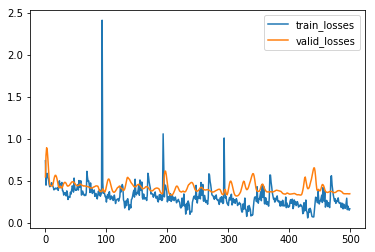

In [64]:
import matplotlib.pyplot as mplot

mplot.plot(train_losses, label='train_losses')
mplot.plot(valid_losses, label='valid_losses')
mplot.legend()
mplot.show()

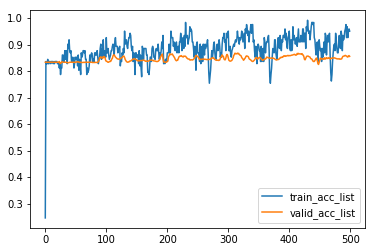

In [65]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc_list, label='train_acc_list')
mplot.plot(valid_acc_list, label='valid_acc_list')
mplot.legend()
mplot.show()